In [33]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

data = yf.download("mara", start="2015-01-01")
data.index = pd.to_datetime(data.index)
data = data.asfreq('B')  # 'B' indicates business days
data = data.ffill().dropna()  # Forward fill NaN values and drop remaining NaNs

[*********************100%%**********************]  1 of 1 completed


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=14613.715, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14614.618, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=14614.580, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=14614.715, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=14611.780, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=14613.971, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=14615.913, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=14613.692, Time=0.39 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=14613.030, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=14611.919, Time=0.12 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=14609.858, Time=0.66 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=14611.807, Time=0.53 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=14612.475, Time=0.79 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=14615.529, Time=0.48 sec
 ARIMA(3,0,2)(0,0,0

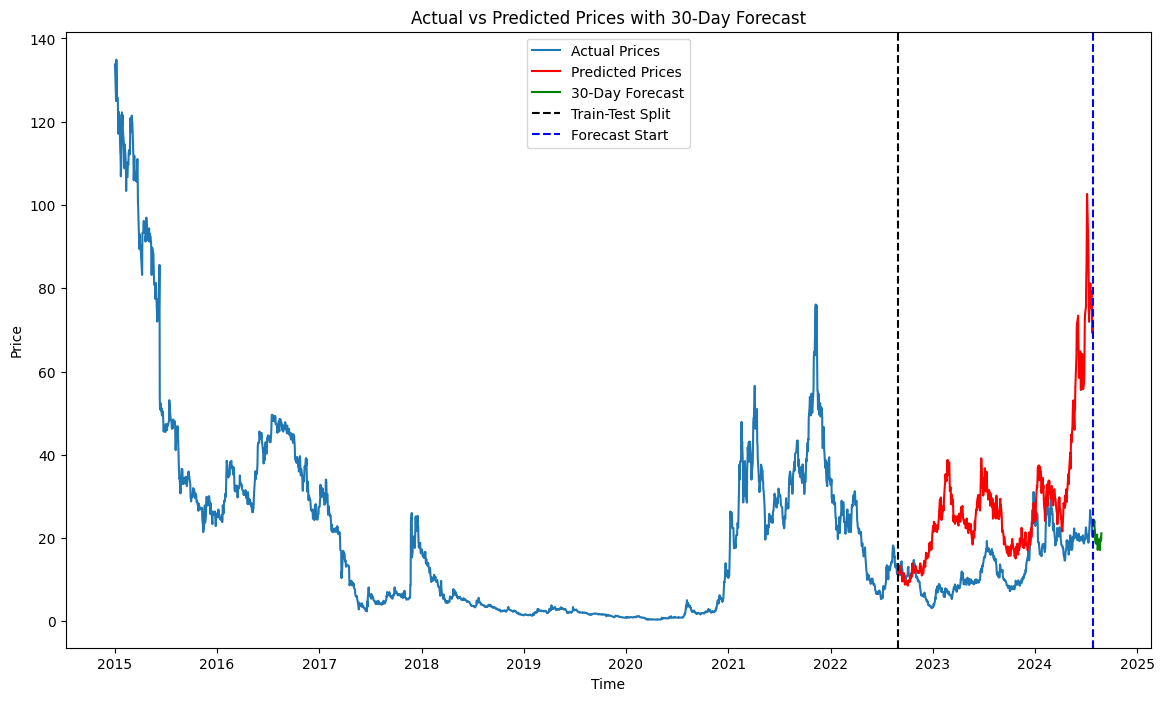

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from arch import arch_model
import statsmodels.api as sm

# Set random seed for reproducibility
np.random.seed(42)

# Load the data
closing_prices = data['Close']

# Compute Returns
returns = closing_prices.pct_change().dropna()
scaled_returns = returns * 100

# Train-Test Split
train_size = int(len(scaled_returns) * 0.8)
train_returns, test_returns = scaled_returns[:train_size], scaled_returns[train_size:]

# Convert train_returns to DataFrame
train_returns = pd.DataFrame(train_returns)
train_returns.rename(columns={train_returns.columns[0]: 'Log Return Rate'}, inplace=True)

# Re-evaluate ARIMA Model Order
arima_model = pm.auto_arima(train_returns, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
order = arima_model.order
arma_mod = sm.tsa.ARIMA(train_returns, order=order).fit()

# GARCH Model Fitting
def fit_garch_model(train_returns):
    best_aic = np.inf
    best_params = None
    for p in range(1, 4):
        for q in range(1, 4):
            model = arch_model(train_returns, vol='Garch', p=p, q=q, dist='StudentsT')
            res = model.fit(update_freq=5, disp='off')
            if res.aic < best_aic:
                best_aic = res.aic
                best_params = (p, q)
    final_model = arch_model(train_returns, vol='Garch', p=best_params[0], q=best_params[1], dist='StudentsT')
    final_res = final_model.fit(update_freq=5, disp='off')
    return final_res

res = fit_garch_model(train_returns)

# Extract parameters
mu = arma_mod.params.get('const', 0)
theta = arma_mod.params.get('ar.L1', 0)
omega = res.params['omega']
alpha = res.params['alpha[1]']
beta = res.params['beta[1]']

# Returns Prediction Function
def returns_predict(period, mu, theta, omega, alpha, beta, res):
    returns_pool = []
    sigma_t = res.conditional_volatility.iloc[-1]
    for i in range(period):
        epsilon_t = sigma_t * np.random.standard_normal()
        sigma_forecast = np.sqrt(omega + alpha * epsilon_t ** 2 + beta * sigma_t ** 2)
        sigma_forecast = np.clip(sigma_forecast, 1e-8, 10)
        epsilon_forecast = sigma_forecast * np.random.standard_normal()
        returns_forecast = mu + epsilon_forecast + theta * epsilon_t
        returns_forecast = np.clip(returns_forecast, -10, 10)
        returns_pool.append(returns_forecast)
        sigma_t = sigma_forecast
    return returns_pool

# Generate Predictions
predicted_returns = returns_predict(len(test_returns), mu, theta, omega, alpha, beta, res)
print(predicted_returns)
predicted_returns_df = pd.DataFrame(predicted_returns, index=test_returns.index, columns=['Predicted Returns'])
test_returns = test_returns.iloc[:len(predicted_returns_df)]
initial_price = closing_prices.iloc[len(train_returns) - 1]
predicted_prices = initial_price * np.exp(predicted_returns_df.cumsum() / 100)

# 30-Day Forecast
forecast_period = 30
new_predicted_returns = returns_predict(forecast_period, mu, theta, omega, alpha, beta, res)
last_date = closing_prices.index[-1]
new_predicted_dates = pd.date_range(last_date + pd.DateOffset(1), periods=forecast_period)
new_predicted_returns_df = pd.DataFrame(new_predicted_returns, index=new_predicted_dates, columns=['Predicted Returns'])
new_initial_price = closing_prices.iloc[-1]
new_predicted_prices = new_initial_price * np.exp(new_predicted_returns_df.cumsum() / 100)

# Plot
plt.figure(figsize=(14, 8))
plt.plot(closing_prices.index, closing_prices, label='Actual Prices')
plt.plot(predicted_prices.index, predicted_prices, label='Predicted Prices', color='red')
plt.plot(new_predicted_prices.index, new_predicted_prices, label='30-Day Forecast', color='green')
plt.axvline(x=closing_prices.index[train_size], color='black', linestyle='--', label='Train-Test Split')
plt.axvline(x=new_predicted_prices.index[0], color='blue', linestyle='--', label='Forecast Start')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices with 30-Day Forecast')
plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=10845.992, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10858.829, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=10859.578, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=10859.695, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=10858.021, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=10858.124, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=10847.961, Time=0.66 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=10847.963, Time=0.60 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=10859.282, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=10860.278, Time=0.31 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=10860.117, Time=0.06 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=10849.579, Time=0.50 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=10846.729, Time=0.73 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 3.565 seconds
[1.271506

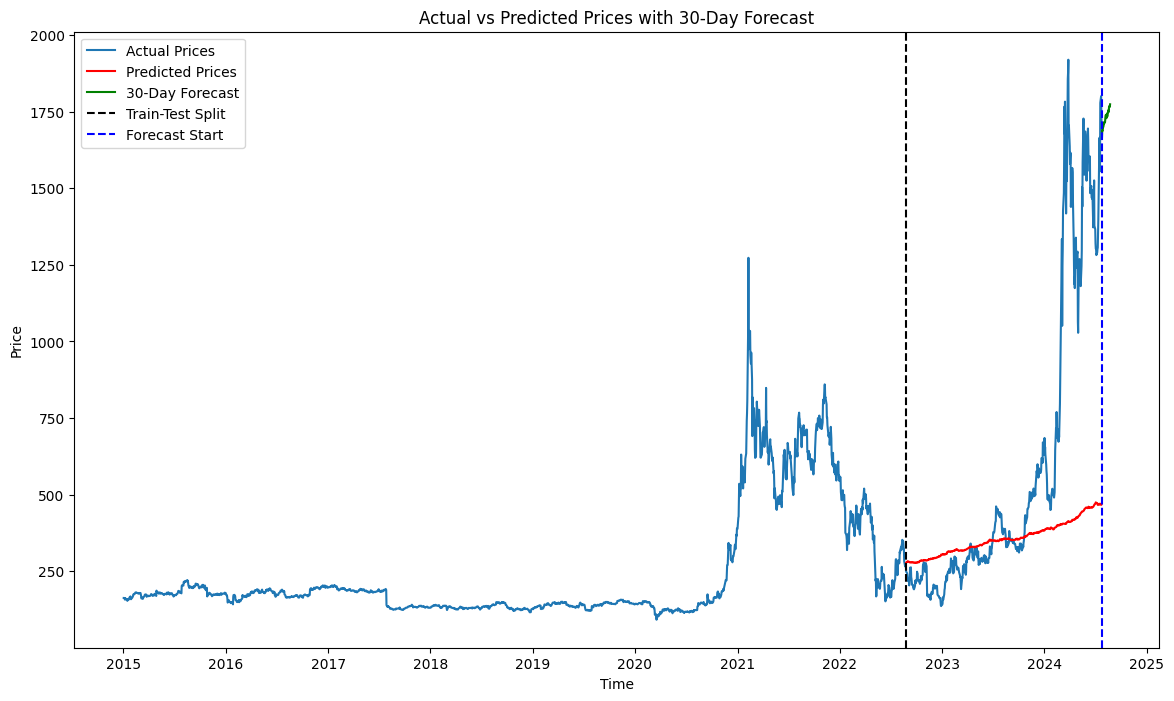

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from arch import arch_model
import statsmodels.api as sm

# Set random seed for reproducibility
np.random.seed(42)

# Load the data
closing_prices = data['Close']

# Compute Returns
returns = closing_prices.pct_change().dropna()
scaled_returns = returns * 100

# Train-Test Split
train_size = int(len(scaled_returns) * 0.8)
train_returns, test_returns = scaled_returns[:train_size], scaled_returns[train_size:]

# Convert train_returns to DataFrame
train_returns = pd.DataFrame(train_returns)
train_returns.rename(columns={train_returns.columns[0]: 'Log Return Rate'}, inplace=True)

# Re-evaluate ARIMA Model Order
arima_model = pm.auto_arima(train_returns, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
order = arima_model.order
arma_mod = sm.tsa.ARIMA(train_returns, order=order).fit()

# GARCH Model Fitting
def fit_garch_model(train_returns):
    best_aic = np.inf
    best_params = None
    for p in range(1, 4):
        for q in range(1, 4):
            model = arch_model(train_returns, vol='Garch', p=p, q=q, dist='StudentsT')
            res = model.fit(update_freq=5, disp='off')
            if res.aic < best_aic:
                best_aic = res.aic
                best_params = (p, q)
    final_model = arch_model(train_returns, vol='Garch', p=best_params[0], q=best_params[1], dist='StudentsT')
    final_res = final_model.fit(update_freq=5, disp='off')
    return final_res

res = fit_garch_model(train_returns)

# Extract parameters
mu = arma_mod.params.get('const', 0)
theta = arma_mod.params.get('ar.L1', 0)
omega = res.params['omega']
alpha = res.params['alpha[1]']
beta = res.params['beta[1]']

# Detect Significant Price Change
def detect_significant_change(returns, threshold=10):
    significant_changes = (returns.abs() > threshold).astype(int)
    return significant_changes

# Returns Prediction Function
def returns_predict(period, mu, theta, omega, alpha, beta, res):
    returns_pool = []
    sigma_t = res.conditional_volatility.iloc[-1]
    for i in range(period):
        epsilon_t = sigma_t * np.random.standard_normal()
        sigma_forecast = np.sqrt(omega + alpha * epsilon_t ** 2 + beta * sigma_t ** 2)
        sigma_forecast = np.clip(sigma_forecast, 1e-8, 10)
        epsilon_forecast = sigma_forecast * np.random.standard_normal()
        returns_forecast = mu + epsilon_forecast + theta * epsilon_t
        returns_forecast = np.clip(returns_forecast, -10, 10)
        returns_pool.append(returns_forecast)
        sigma_t = sigma_forecast
    return returns_pool

# Generate Predictions
predicted_returns = returns_predict(len(test_returns), mu, theta, omega, alpha, beta, res)
print(predicted_returns)
predicted_returns_df = pd.DataFrame(predicted_returns, index=test_returns.index, columns=['Predicted Returns'])
test_returns = test_returns.iloc[:len(predicted_returns_df)]
initial_price = closing_prices.iloc[len(train_returns) - 1]
predicted_prices = initial_price * np.exp(predicted_returns_df.cumsum() / 100)

# 30-Day Forecast
forecast_period = 30
new_predicted_returns = returns_predict(forecast_period, mu, theta, omega, alpha, beta, res)
last_date = closing_prices.index[-1]
new_predicted_dates = pd.date_range(last_date + pd.DateOffset(1), periods=forecast_period)
new_predicted_returns_df = pd.DataFrame(new_predicted_returns, index=new_predicted_dates, columns=['Predicted Returns'])
new_initial_price = closing_prices.iloc[-1]
new_predicted_prices = new_initial_price * np.exp(new_predicted_returns_df.cumsum() / 100)

# Plot
plt.figure(figsize=(14, 8))
plt.plot(closing_prices.index, closing_prices, label='Actual Prices')
plt.plot(predicted_prices.index, predicted_prices, label='Predicted Prices', color='red')
plt.plot(new_predicted_prices.index, new_predicted_prices, label='30-Day Forecast', color='green')
plt.axvline(x=closing_prices.index[train_size], color='black', linestyle='--', label='Train-Test Split')
plt.axvline(x=new_predicted_prices.index[0], color='blue', linestyle='--', label='Forecast Start')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices with 30-Day Forecast')
plt.show()
